In [ ]:
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Selecting a specific data from the entire dataset

In [ ]:
# extracting files
!unzip '/content/drive/MyDrive/CV_project/Dataset/WIDER_train.zip'
!unzip '/content/drive/MyDrive/CV_project/Dataset/WIDER_val.zip'
!unzip '/content/drive/MyDrive/CV_project/Dataset/wider_face_split.zip'

In [ ]:
# reading files
import pandas as pd

# specify path of the data
path_train = '/content/wider_face_split/wider_face_train_bbx_gt.txt'
path_val = '/content/wider_face_split/wider_face_val_bbx_gt.txt'

# reading data
train = pd.read_csv(path_train,header=None)
val = pd.read_csv(path_val,header=None)

In [ ]:
train.head()

,0
0,0--Parade/0_Parade_marchingband_1_849.jpg
1,1
2,449 330 122 149 0 0 0 0 0 0
3,0--Parade/0_Parade_Parade_0_904.jpg
4,1


In [ ]:
# pre-processing data
# this function accepts the dataframe and returns modified dataframe
def reformat(df):

  # fetch values of first column
  values = df[0].values

  # creating empty lists
  names=[]
  num_faces=[]
  bbox=[]

  # fetch values into corresponding lists
  for i in range(len(values)):

      # if an image
      if ".jpg" in values[i]:

        # no. of faces
        num=int(values[i+1])

        # append image name to list
        names.append(values[i])

        # append no. of faces to list
        num_faces.append(num)

        # create bbox list
        box=[]
        for j in range(i+2,i+2+num):
          box.append(values[j])

        # append bbox list to list
        bbox.append(box)

  return pd.DataFrame({'name':names,'num_faces':num_faces,'bbox':bbox})

In [ ]:
# pre-processing the data
train = reformat(train)
val = reformat(val)

In [ ]:
# first 5 rows of the pre-processed data
train.head()

,name,num_faces,bbox
0,0--Parade/0_Parade_marchingband_1_849.jpg,1,[449 330 122 149 0 0 0 0 0 0 ]
1,0--Parade/0_Parade_Parade_0_904.jpg,1,[361 98 263 339 0 0 0 0 0 0 ]
2,0--Parade/0_Parade_marchingband_1_799.jpg,21,"[78 221 7 8 2 0 0 0 0 0 , 78 238 14 17 2 0 0 0..."
3,0--Parade/0_Parade_marchingband_1_117.jpg,9,"[69 359 50 36 1 0 0 0 0 1 , 227 382 56 43 1 0 ..."
4,0--Parade/0_Parade_marchingband_1_778.jpg,35,"[27 226 33 36 1 0 0 0 2 0 , 63 95 16 19 2 0 0 ..."


In [ ]:
# adding full path
train['name'] = train['name'].apply(lambda x: 'WIDER_train/images/'+x )
val['name']   = val['name'].apply(lambda x: 'WIDER_val/images/'+x )

In [ ]:
# converting bbox to floating point
import numpy as np
train['bbox'] = train['bbox'].apply(lambda row:[ np.float_(annos.split()) for annos in row] )
val['bbox']   = val['bbox'].apply(lambda row:[ np.float_(annos.split()) for annos in row] )

In [ ]:
# extracting class names
train['class']= train['name'].apply(lambda x:x.split("/")[2].split("--")[1])
val['class']  = val['name'].apply(lambda x:x.split("/")[2].split("--")[1])

In [ ]:
# reading class names
easy_df = pd.read_csv('/content/drive/MyDrive/CV_project/Dataset/easy.txt',header=None)
easy_labels = easy_df[0].values

In [ ]:
# creating empty dataframes
train_df, val_df= pd.DataFrame(), pd.DataFrame()

# fetching rows of easy classes only
for i in easy_labels:
  train_df = pd.concat( [train_df, train[train['class']==i]] )
  val_df   = pd.concat( [val_df, val[val['class']==i]] )

In [ ]:
# shape of dataframe
train_df.shape, val_df.shape

((2307, 4), (577, 4))

In [ ]:
# first 5 rows
train_df.iloc[0]

name         WIDER_train/images/40--Gymnastics/40_Gymnastic...
num_faces                                                    1
bbox         [[480.0, 212.0, 102.0, 120.0, 0.0, 0.0, 0.0, 0...
class                                               Gymnastics
Name: 7983, dtype: object

## Preprocessing Data as per YOLO format

In [ ]:
import pandas as pd

# Assuming you have a DataFrame named 'df'
# You can create a CSV file to store the DataFrame
train_df.to_csv('train_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)

In [ ]:
# custom annotation format
idx=0
values = train_df.values[idx]
print(values)

['WIDER_train/images/40--Gymnastics/40_Gymnastics_Gymnastics_40_785.jpg' 1
 list([array([480., 212., 102., 120.,   0.,   0.,   0.,   0.,   0.,   0.])])
 'Gymnastics']


In [ ]:
def create_annotation(df):
  idx = 1
  # creating empty list to store annotations
  dataset_dicts = []

  # for each image
  for idx, v in enumerate(df.values):

    # create annotation dict
    record = {}

    # image name
    filename = v[0]

    # height and width of an image
    height, width = cv2.imread(filename).shape[:2]

    # assign values to fields
    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width

    # create bbox list
    objs = []

    # for each face in an image
    for i in range(len(v[2])):

      # bounding box coordinates
      annos = v[2][i]

      # unpack values
      x1, y1, w, h = annos[0], annos[1], annos[2], annos[3]

      # find bottom right corner
      xc, yc = x1 + w/2, y1 + h/2
      xc = xc / width
      w = w / width
      yc = yc / height
      h = h / height
      # create bbox dict
      obj = {   "bbox": [xc, yc, w, h]
            }

      # append bbox dict to bbox list
      objs.append(obj)

    # assign bbox list to annotation dict
    record["annotations"] = objs

    # append annotation dict to list
    dataset_dicts.append(record)

  return dataset_dicts

In [ ]:
# create standard annotations for training and validation datasets
train_annotation = create_annotation(train_df)
val_annotation   = create_annotation(val_df)

In [ ]:
# standard annotation of an image
len(train_annotation)

2307

## Creating images and labels folder inside train and valid folder

In [ ]:
import shutil
df = pd.DataFrame(train_df)

# Extract image filenames from the 'image_filename' column and copy to the "train" folder
for index, row in df.iterrows():
    source_image_path = row['name']
    destination_image_path = os.path.join("/content/training/train/train", os.path.basename(source_image_path))

    try:
        shutil.copyfile(source_image_path, destination_image_path)
        print(f"Image '{os.path.basename(source_image_path)}' copied to '/content/training/train/train'.")
    except FileNotFoundError:
        print(f"Image '{os.path.basename(source_image_path)}' not found.")

print("Images copied to the 'train' folder.")

In [ ]:
import shutil
df = pd.DataFrame(val_df)

# Extract image filenames from the 'image_filename' column and copy to the "train" folder
for index, row in df.iterrows():
    source_image_path = row['name']
    destination_image_path = os.path.join("/content/training/train/valid", os.path.basename(source_image_path))

    try:
        shutil.copyfile(source_image_path, destination_image_path)
        print(f"Image '{os.path.basename(source_image_path)}' copied to '/content/training/train/valid'.")
    except FileNotFoundError:
        print(f"Image '{os.path.basename(source_image_path)}' not found.")

print("Images copied to the 'train' folder.")

In [ ]:
import os

# Loop through each dictionary in the list
for item in train_annotation:
    file_name = item['file_name']
    annotations = item['annotations']

    # Replace the ".jpg" extension with ".txt" in the file name
    label_file_name = os.path.join("/content/training/train/labels", os.path.splitext(os.path.basename(file_name))[0] + ".txt")

    # Open the label file for writing
    with open(label_file_name, 'w') as label_file:
        for annotation in annotations:
            bbox = annotation['bbox']
            # Add a zero element before the bbox values and write to the file
            label_file.write("0 " + " ".join(map(str, bbox)) + "\n")

print("Label files created and stored in the 'labels' folder.")

Label files created and stored in the 'labels' folder.


In [ ]:
import os

# Loop through each dictionary in the list
for item in val_annotation:
    file_name = item['file_name']
    annotations = item['annotations']

    # Create a label file based on the "file_name"
    label_file_name = os.path.join("/content/training/valid/labels", os.path.basename(file_name) + ".txt")

    # Open the label file for writing
    with open(label_file_name, 'w') as label_file:
        for annotation in annotations:
            bbox = annotation['bbox']
            # Add a zero element before the bbox values and write to the file
            label_file.write("0 " + " ".join(map(str, bbox)) + "\n")

print("Label files created and stored in the 'labels' folder.")

Label files created and stored in the 'labels' folder.


In [ ]:
import os

# Specify the path to the folder containing the files
folder_path = "/content/training/valid/labels"

# List all files in the folder
files = os.listdir(folder_path)

# Iterate through the files and rename them to remove ".jpg"
for file_name in files:
    if file_name.endswith(".jpg.txt"):
        new_name = file_name.replace(".jpg.txt", ".txt")
        old_path = os.path.join(folder_path, file_name)
        new_path = os.path.join(folder_path, new_name)
        os.rename(old_path, new_path)
        print(f"Renamed: {file_name} -> {new_name}")


## Training YOLO

In [ ]:
# download the library ultralytics
!git clone https://github.com/ultralytics/ultralytics.git

Cloning into 'ultralytics'...
remote: Enumerating objects: 20588, done.
remote: Counting objects: 100% (1775/1775), done.
remote: Compressing objects: 100% (998/998), done.
remote: Total 20588 (delta 1084), reused 1222 (delta 773), pack-reused 18813
Receiving objects: 100% (20588/20588), 11.45 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (14249/14249), done.


In [ ]:
from ultralytics import YOLO

In [ ]:
# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from scratch


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
# Use the model
model.train(data='/content/training/customdata.yaml', epochs=20)  # train the model

Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/training/customdata.yaml, epochs=20, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, f

train: Scanning /content/training/train/labels.cache... 2307 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2307/2307 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/training/valid/labels.cache... 577 images, 0 backgrounds, 0 corrupt: 100%|██████████| 577/577 [00:00<?, ?it/s]


Plotting labels to runs/detect/train222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train222
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.67G      3.559      4.145      3.612         40        640: 100%|██████████| 145/145 [01:24<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


                   all        577       3026     0.0138     0.0314    0.00283   0.000968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       3.7G      2.614      2.696      2.297         19        640: 100%|██████████| 145/145 [01:22<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


                   all        577       3026      0.448      0.227      0.228     0.0986

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       3.6G       2.33      2.056      1.932         39        640: 100%|██████████| 145/145 [01:17<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]


                   all        577       3026      0.534       0.26       0.28      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.28G      2.152      1.768      1.768         14        640: 100%|██████████| 145/145 [01:17<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


                   all        577       3026      0.678      0.347      0.401      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.93G      2.038        1.6      1.661         18        640: 100%|██████████| 145/145 [01:17<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.72it/s]


                   all        577       3026        0.7      0.379      0.433       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.71G      1.956      1.495       1.59          8        640: 100%|██████████| 145/145 [01:24<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


                   all        577       3026      0.684      0.405      0.459      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       4.5G      1.884      1.409      1.551         16        640: 100%|██████████| 145/145 [01:21<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.70it/s]


                   all        577       3026      0.777      0.417      0.491      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.86G      1.804      1.346      1.508         47        640: 100%|██████████| 145/145 [01:20<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.36it/s]


                   all        577       3026      0.781      0.419      0.501       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.54G      1.787      1.303      1.486         13        640: 100%|██████████| 145/145 [01:22<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.66it/s]


                   all        577       3026      0.818      0.438      0.514      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.04G      1.749      1.234      1.457         18        640: 100%|██████████| 145/145 [01:19<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.57it/s]


                   all        577       3026      0.792      0.461      0.537      0.292
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.95G      1.684      1.196      1.427         20        640: 100%|██████████| 145/145 [01:18<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.46it/s]


                   all        577       3026      0.804      0.458      0.536      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.84G      1.647      1.143      1.431          8        640: 100%|██████████| 145/145 [01:12<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.67it/s]


                   all        577       3026      0.822      0.479       0.56      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.96G      1.636      1.099      1.399         15        640: 100%|██████████| 145/145 [01:16<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]


                   all        577       3026      0.799      0.472      0.553      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.38G      1.601      1.059      1.385         18        640: 100%|██████████| 145/145 [01:15<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.45it/s]

                   all        577       3026      0.796      0.476      0.563      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.47G      1.575       1.05      1.377         10        640: 100%|██████████| 145/145 [01:12<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]


                   all        577       3026      0.843      0.486       0.58      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.29G      1.561      1.015      1.366         29        640: 100%|██████████| 145/145 [01:11<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.47it/s]


                   all        577       3026      0.821      0.504      0.587       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.75G      1.543     0.9987      1.348         19        640: 100%|██████████| 145/145 [01:10<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.66it/s]


                   all        577       3026      0.831      0.492      0.578      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.83G      1.524     0.9659      1.338          4        640: 100%|██████████| 145/145 [01:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


                   all        577       3026      0.851      0.516      0.603      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.54G      1.495     0.9512      1.316         10        640: 100%|██████████| 145/145 [01:13<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]


                   all        577       3026      0.838      0.519      0.603      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.73G      1.468     0.9132      1.307          6        640: 100%|██████████| 145/145 [01:09<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.58it/s]


                   all        577       3026      0.826      0.519      0.608      0.348

20 epochs completed in 0.504 hours.
Optimizer stripped from runs/detect/train222/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train222/weights/best.pt, 6.2MB

Validating runs/detect/train222/weights/best.pt...
Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


                   all        577       3026      0.827      0.519      0.608      0.348
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train222


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fd64670a7a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

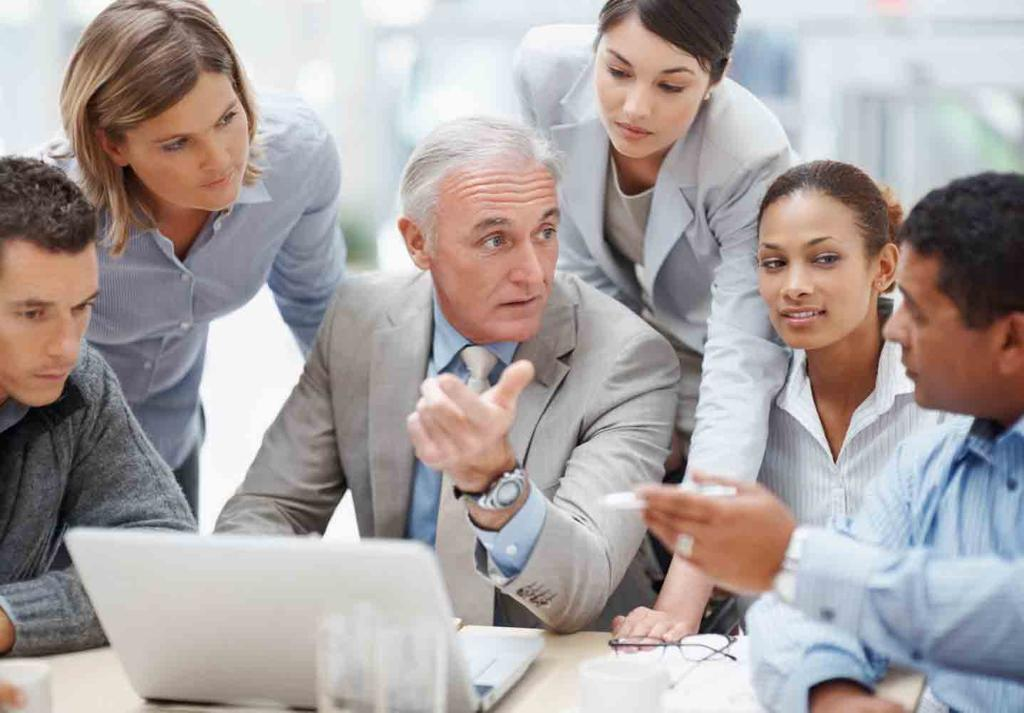

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
image_folder = "/content/training/valid/images"
annotation_folder = "/content/training/valid/labels"

# Specify the image file name (without extension)
image_name = "11_Meeting_Meeting_11_Meeting_Meeting_11_102"  # Replace with your image file name
image_path = os.path.join(image_folder, f"{image_name}.jpg")
annotation_path = os.path.join(annotation_folder, f"{image_name}.txt")

from PIL import Image
import IPython.display as display
# Load the image
image = cv2.imread(image_path)

# Display the image using cv2_imshow
cv2_imshow(image)

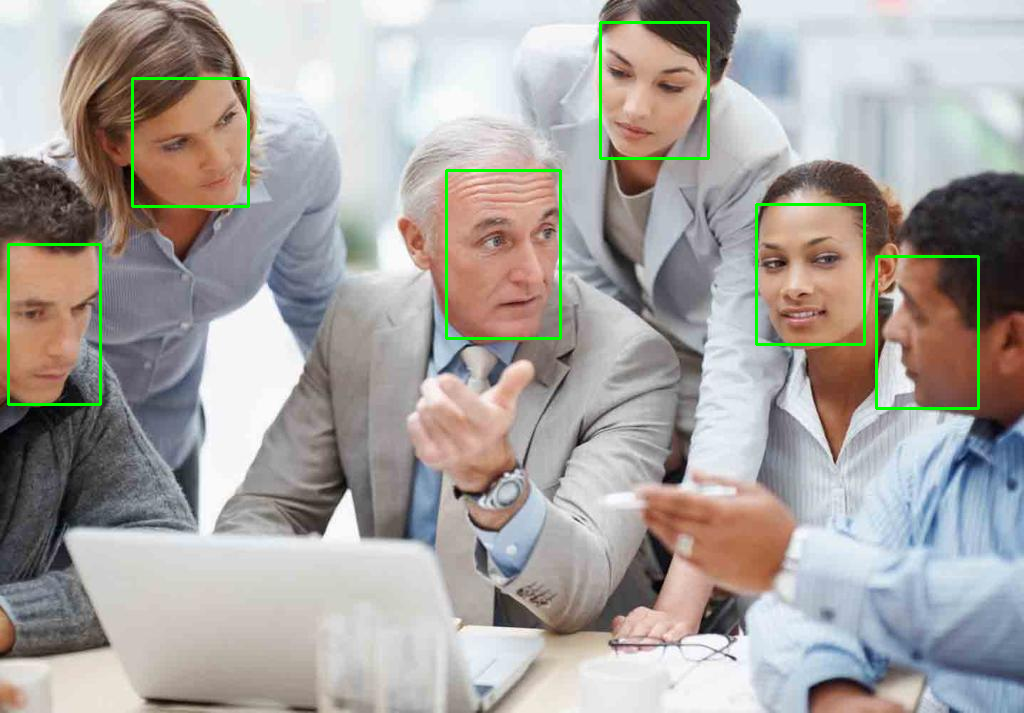

In [ ]:
# Read and parse the YOLO format annotation file
with open(annotation_path, 'r') as annotation_file:
    lines = annotation_file.readlines()
    for line in lines:
        values = line.strip().split()
        class_id = int(values[0])
        x_center, y_center, width, height = map(float, values[1:])

        # Convert YOLO format to coordinates
        x1 = int((x_center - width / 2) * image.shape[1])
        y1 = int((y_center - height / 2) * image.shape[0])
        x2 = int((x_center + width / 2) * image.shape[1])
        y2 = int((y_center + height / 2) * image.shape[0])

        # Draw bounding box on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding boxes
cv2_imshow(image)